# Imports

In [ ]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sklearn.metrics
# TensorFlow and tf.keras
import tensorflow as tf
import random
from tqdm import tqdm
np.seterr(divide='ignore', invalid='ignore')

import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# data loading and processing

###Downloading the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

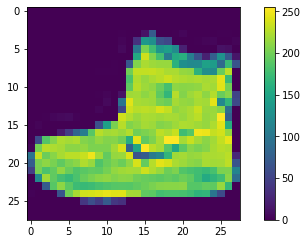

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

###Preprocessing

In [ ]:
train_images.shape

'''flatten vector'''
train_images_fla = []
test_images_fla = []
for row in train_images:
  train_images_fla.append(row.flatten())

for row in test_images:
  test_images_fla.append(row.flatten())

train_images_fla = np.array(train_images_fla)
test_images_fla = np.array(test_images_fla)


Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

print(train_images_fla.shape)
print(test_images_fla.shape)

(60000, 784)
(10000, 784)


In [ ]:
X_train = np.array((train_images_fla - np.mean(train_images_fla, axis=0)) / 255.0)
X_test = np.array((test_images_fla - np.mean(test_images_fla, axis=0)) / 255.0)

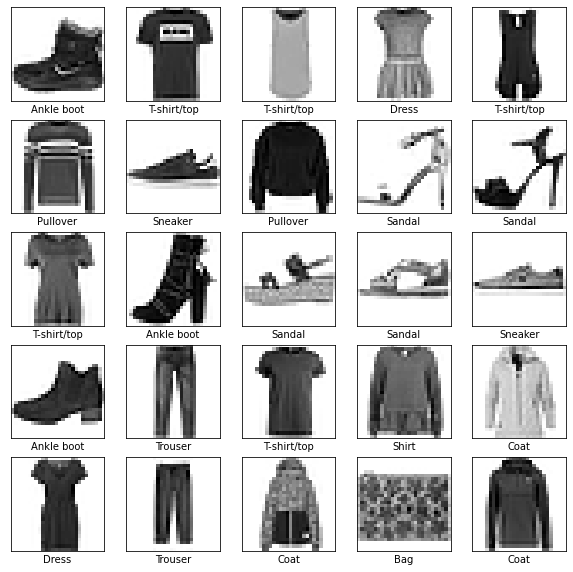

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Neural Network Implementation

Implement the cost function as a class that holds the functions needed:

In [ ]:
class Cross_Entropy:
    def __init__(self, activation_fn):
      
        self.activation_fn = activation_fn

    def activation(self, z):
      return self.activation_fn.activation(z)

    def loss(y_true, y_pred):
   
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -(y_true * np.log(y_pred+1e-9)).sum(axis=-1).mean()

        return loss

    @staticmethod
    def prime(Y, AL):  
        return AL - Y

    def delta(self, y_true, y_pred):
        return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)

### ACTIVATION Functions:

Implement activation functions as functions

In [ ]:
import numpy as np
class Relu:
    @staticmethod
    def activation(z):
      return np.maximum(0,z)
    def prime(z):
        z[z<=0] = 0
        z[z>0] = 1
        return z

class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    def prime(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))

class tanh:
    @staticmethod
    def activation(z):
	    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    def prime(z):
      return 1 - np.power(tanh.activation(z), 2)

class softmax:
    @staticmethod
    def activation(x):
      e = np.exp(x-np.max(x))
      # print("e",e)
      s = np.sum(e, axis=1, keepdims=True)
      return e/s
    @staticmethod
    def prime(z):
        return softmax.activation(z)*softmax.activation(1-z)

class leakyRelu:
    @staticmethod
    def activation(z):
      alpha = 0.3
      return np.maximum(0,z) + alpha * np.min(z,0)
    def prime(z):
        z[z<=0] = 0
        z[z>0] = 1
        return z

### MLP

In [ ]:
class MLP:
    # Constructor:
    def __init__(self, dimensions, activations):
        """
        dimensions as list:  Dimensions of the neural net. (input, hidden layer(s), output)
        activations as list :  Activations functions.

        """
        self.n = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.w = {}
        self.b = {}
        self.lambd = None
        self.activations = {}
        # initialize the neural net
        for i in range(len(dimensions) - 1):
            self.w[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.b[i + 1] = np.random.randn(dimensions[i + 1])
            self.activations[i + 2] = activations[i]

    def forward(self, x):
    

        z = {}
        a = {1: x}  
        for i in range(1, self.n):
            
            z[i + 1] = np.dot(a[i], self.w[i]) + self.b[i]
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])

        return z, a  

    # function that updates weights after gradient descent and uses l2 reg
    def _update_w_b(self, index, dw, delta):
        """
        Method to update weights and biases.
        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """
        dw += (self.lambd) * self.w[index] 
        self.w[index] -= self.learning_rate * dw
        self.b[index] -= self.learning_rate * np.mean(delta, 0)

    def _back_prop(self, z, a, y_true):

        # Determine partial derivative and delta for the output layer.
        delta = self.loss.delta(y_true, a[self.n])
        dw = np.dot(a[self.n - 1].T, delta)

        update_params = {
            self.n - 1: (dw, delta)
        }

        for i in reversed(range(2, self.n)):
            delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(z[i])
            dw = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (dw, delta)
	
        # Update the weights and biases
        for k, v in update_params.items():
            self._update_w_b(k, v[0], v[1])
    
    # Set plot to True to plot the test and train accuracy against number of epoches
    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size, loss, lambd, learning_rate=1e-3, plot= False):
        y_train = np.eye(10)[y_train]
        y_test = np.eye(10)[y_test]
      
        # Initiate the loss object with the final activation function
        self.loss = loss(self.activations[self.n])
        self.learning_rate = learning_rate
        self.lambd = lambd

        train_acc = []
        test_acc = []
        losses=[]
        xaxis = []

        for i in tqdm(range(epochs)):

            # one minibatch at one epoch
            ind = np.random.choice(X_train.shape[0], batch_size)
            # print(i)
            X_batch = X_train[ind,:]
            Y_batch = y_train[ind]
 
            z, a = self.forward(X_batch)
            self._back_prop(z, a, Y_batch)
            y_pred = a[self.n]
            losses.append(loss.loss(Y_batch, y_pred)) 
            
            '''compute acc for every epoch'''
            # train_cur_acc = np.mean(self.predict(X_train) == np.argmax(y_train,axis = 1))
            # test_cur_acc = np.mean(self.predict(X_test) == np.argmax(y_test,axis = 1))
            # #print("train accuracy", train_cur_acc)
            # train_acc.append(train_cur_acc)
            # test_acc.append(np.mean(self.predict(X_test) == np.argmax(y_test,axis = 1)))


            '''plot training and testing acc'''
            # if (i+1) % 100 == 0:
            #     xaxis.append(i+1)
            #     train_cur_acc = np.mean(self.predict(X_train) == np.argmax(y_train,axis = 1))
            #     train_acc.append(train_cur_acc)
            #     test_cur_acc = np.mean(self.predict(X_test) == np.argmax(y_test,axis = 1))
            #     test_acc.append(test_cur_acc)  
                    
            #     print("Training accuracy:", train_acc[-1])
            #     print("Test accuracy:", test_acc[-1])
            #     plt.plot(xaxis, train_acc)
            #     plt.plot(xaxis, test_acc)
            #     plt.title("training and test accuracy for every 100 epochs")
            #     plt.legend(["training", "test"],loc = 'best')
            #     plt.ylabel('Accuracy')
            #     plt.xlabel('epochs')
            #     plt.grid()
            #     plt.show()


        '''final acc'''
        train_final_acc = np.mean(self.predict(X_train) == np.argmax(y_train,axis = 1))
        test_final_acc = np.mean(self.predict(X_test) == np.argmax(y_test,axis = 1))
        train_acc = train_final_acc
        test_acc = test_final_acc
        
        print("train acc", train_final_acc)
        print("test acc", test_final_acc)
        
        '''plot the loss'''
        # plt.figure()    
        # plt.plot(losses)
        # plt.ylabel('Loss Function')
        # plt.xlabel('epoches')
        # plt.grid()
        # plt.show()

        return train_acc, test_acc

    def predict(self, x):
        
        z, a = self.forward(x)
        # return a[self.n_layers]
        pred = np.argmax(a[self.n], axis=1)
        return pred

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))
    
    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)


    def check(self, X, Y):
        W = self.w[3]
        D, C = 128, 10
        diff = np.zeros((128, 10))
        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4
                W_hat = W
                W = W_hat + epsilon
                J1 = self.ce(X, Y)
                
                W = W_hat - epsilon
                J2 = self.ce(X, Y)

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, Y)[j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum()
                diff[i, j] = diff[i, j] / np.square(derived_grad + numeric_grad).sum()
        return diff.sum()

        
    def evaluate_acc (True_label,Predicted_label):
        return np.sum(True_label == Predicted_label)/Predicted_label.shape[0]

#Task 3: Run the experiments and report

## Task 3.1 Different hidden layers


MLP with 2 hidden layers 128 units ReLU

In [ ]:
mlp_2 = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, test_log = mlp_2.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)


100%|██████████| 1500/1500 [00:19<00:00, 77.72it/s]


train acc 0.88455
test acc 0.8627


Hyperparameter tuning

100%|██████████| 1500/1500 [00:18<00:00, 81.92it/s]


train acc 0.15188333333333334
test acc 0.1564


100%|██████████| 1500/1500 [00:17<00:00, 83.54it/s]


train acc 0.4172666666666667
test acc 0.4175


100%|██████████| 1500/1500 [00:18<00:00, 82.88it/s]


train acc 0.7184
test acc 0.7138


100%|██████████| 1500/1500 [00:19<00:00, 78.56it/s]


train acc 0.8075666666666667
test acc 0.7961


100%|██████████| 1500/1500 [00:19<00:00, 75.51it/s]


train acc 0.83795
test acc 0.8228


100%|██████████| 1500/1500 [00:18<00:00, 81.48it/s]


train acc 0.8735166666666667
test acc 0.8585


100%|██████████| 1500/1500 [00:18<00:00, 82.35it/s]


train acc 0.8723333333333333
test acc 0.8545


100%|██████████| 1500/1500 [00:17<00:00, 86.31it/s]


train acc 0.6957666666666666
test acc 0.6796


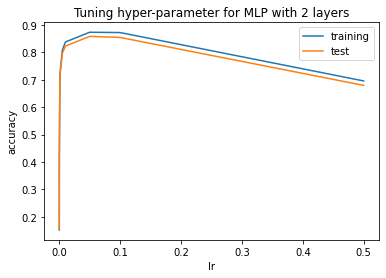

[0.1564, 0.4175, 0.7138, 0.7961, 0.8228, 0.8585, 0.8545, 0.6796]


In [ ]:
learing_rate = [1e-05, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]


train_acc = []
test_acc = []

for l in learing_rate:
    mlp_2 = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
    train_log, test_log = mlp_2.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=l, plot=True)
    train_acc.append(train_log)
    test_acc.append(test_log)

plt.plot(learing_rate, train_acc)
plt.plot(learing_rate, test_acc)
plt.title("Tuning hyper-parameter for MLP with 2 layers")
plt.ylabel("accuracy")
plt.legend(["training", "test"], loc ="best")
plt.xlabel("lr")
plt.show()
print(test_acc)

Monitoring training accuracy against the number of iterations shows that training accuracy starts to stay constant after epoche 60. So, we set epochs =60 and then tune learning rate.


1 hidden layer 128 units ReLU

In [ ]:
mlp_1 = MLP((784, 128, 10), (Relu, softmax))
train_log, val_log = mlp_1.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.0001, plot=True)


100%|██████████| 1500/1500 [00:14<00:00, 101.16it/s]


train acc 0.7289333333333333
test acc 0.7239


 MLP with no hidden layers

In [ ]:
mlp_0 = MLP((784, 10), (softmax,))
train_log, test_log = mlp_0.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.0001, plot=True)


100%|██████████| 1500/1500 [00:07<00:00, 196.80it/s]


train acc 0.7175666666666667
test acc 0.7109


## Task 3.2 Different Activation functions 

### MLP with 2 hidden layers 128 units with Leaky-ReLU

In [ ]:
mlp_leakyRelu = MLP((784, 128, 128, 10), (leakyRelu, leakyRelu, softmax))
train_log, test_log = mlp_leakyRelu.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy, lambd = 0, learning_rate=0.1, plot=True)


### MLP with 2 hidden layers 128 units with tanh activations

In [ ]:
# #create a list of alpha values to tune on
# learing_rate = np.array([1e-2, 1e-1, 5e-1])
# best_score = 0
# n=0
# Acc=np.zeros(3)
# # loop over the alphas
# for i in learing_rate:
#       mn = MLP((784, 128, 128, 10), [tanh,tanh,softmax])
#       score = kfoldCV(x_train,y_train,5, mn,i,0, 60)[1]
#       Acc[n]= score
#       n+=1
#       if score > best_score:
#          best_score = score
#          best_lr = i
#       print(f'for learning_rate= {i}  => score = {score}, best score = {best_score}')
# print(f'Best learning_rate: {best_lr}')
# plt.plot(learing_rate, Acc)
# plt.ylabel('Accuracy')
# plt.xlabel('learning_rate')
# plt.grid()
# plt.show()

In [ ]:
nn = MLP((784, 128, 128, 10), (tanh, tanh, softmax))
train_log, test_log = nn.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
# print("Accuracy on test data", evaluate_acc(nn.predict(x_test),y_test))


100%|██████████| 1500/1500 [00:51<00:00, 29.23it/s]


train acc 0.3323833333333333
test acc 0.3287


## Task 3.3 L2 regularization

Tuning Lambda

In [ ]:
regs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

train_acc = []
test_acc = []

for l in regs:
    nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
    train_log, test_log = nn.fit(X_train, Y_train, X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = l, learning_rate=0.1, plot=True)
    train_acc.append(train_log)
    test_acc.append(test_log)

plt.plot(regs, train_acc)
plt.plot(regs, test_acc)
plt.title("Tuning hyper-parameter for regularization")
plt.ylabel("accuracy")
plt.legend(["training", "test"], loc ="best")
plt.xlabel("lambda")
plt.show()
print(test_acc)



## Task 3.4 Unnormalized images

In [ ]:
# n_features= x_train0.shape[1]*x_train0.shape[2]
# x_train_unnorm = x_train0.reshape(-1, n_features)
# x_test_unnorm = x_test0.reshape(-1, n_features)

In [ ]:
model = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
train_log, val_log = model.fit(train_images_fla, Y_train, test_images_fla, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=1e-6, plot=True)
# print("Accuracy on test data", evaluate_acc(nn.predict(x_test_unnorm),y_test))

## Task 3.5 ConvNet with 2 convolutional and 2 fully connected layers

In [ ]:
# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [ ]:
num_filters = 4
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (train_images.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
model = Sequential()
model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape
model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(1600, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # output layer

# apply dropout and padding
model_2 = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(2304, activation='relu'),
  Dense(num_classes, activation='softmax'),
])

In [ ]:
# Plot model 
keras.utils.plot_model(model_2, "cnn_model.png", show_shapes=True)

In [ ]:
# Summary of the model 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 1600)             

In [ ]:
model_2.summary()

In [ ]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
# Compile the model
model_2.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("cnn_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


fitting model 1

In [ ]:
# Fitting the model
history = model.fit(
  train_images,
  train_labels, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

fitting Model 2 with zero padding and dropout

In [ ]:
# Fitting the model 2
history = model_2.fit(
  train_images,
  train_labels, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

RuntimeError: ignored

In [ ]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('cnn_model_1.png')

Tuning number of filters

In [ ]:
filter_num_list = [1,4,8,12]

for num_filters in filter_num_list:
    filter_size = 3
    pool_size   = 2
    num_classes = 10
    batch_size  = 64
    input_shape = (train_images.shape[1:]) # (28, 28, 1)
    strides     = 1
    padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                        # When padding="same" and strides=1, the output has the same size as the input
    model = Sequential()
    model.add(Conv2D(filters = 4 * num_filters,
                    kernel_size = filter_size,
                    strides     = strides,
                    input_shape = input_shape,
                    padding     = padding,
                    activation  = 'relu')) # Sequential model needs the input shape
    model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

    model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    #model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
    model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
    model.add(Dense(1600, activation='relu'))
    model.add(Dense(num_classes, activation='softmax')) # output layer

    # Compile the model
    model.compile(
        'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
        loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
        metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
        )
    
    # Train the mdoel

    epochs = 10

    # Saving the model during training to be used later
    checkpoint = ModelCheckpoint("cnn_best_model.hdf5",  # saving the best model
                                monitor='val_loss', verbose=1,
                                save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                                save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                                mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                                save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.
    
    # Fitting the model
    print("fitting model with number of filters = ", num_filters)
    history = model.fit(
        train_images,
        train_labels, 
        epochs=epochs,                # number of training epochs
        batch_size=batch_size,
        verbose = 1,
        validation_data=(test_images, test_labels), # validation data
        callbacks=[checkpoint]      # callback to save the model during trainings 
    )


<BarContainer object of 4 artists>

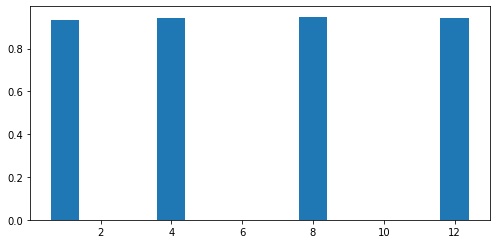

In [ ]:

acc_list = [0.9335, 0.9426, 0.9493, 0.9423]

filter_num_list = [1,4,8,12]


x = np.array([10,20,30,40,50])
bar=4

# plot the training results
plt.bar(filter_num_list, acc_list)



In [ ]:

train_images.shape
train_x = train_images[10,]
train_x.shape

(28, 28)

In [ ]:
train_size_list = [1,10,100,1000,10000]


for train_size in train_size_list:
    train_x = train_images[train_size,:]
    train_y = train_labels[train_size]

    # Reshape the images.
    train_images = np.expand_dims(train_x, axis=3)
    test_images = np.expand_dims(test_images, axis=3)

    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    filter_size = 8
    pool_size   = 2
    num_classes = 10
    batch_size  = 64
    input_shape = (train_images.shape[1:]) # (28, 28, 1)
    strides     = 1
    padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                        # When padding="same" and strides=1, the output has the same size as the input
    model = Sequential()
    model.add(Conv2D(filters = 4 * num_filters,
                    kernel_size = filter_size,
                    strides     = strides,
                    input_shape = input_shape,
                    padding     = padding,
                    activation  = 'relu')) # Sequential model needs the input shape
    model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

    model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    #model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
    model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
    model.add(Dense(1600, activation='relu'))
    model.add(Dense(num_classes, activation='softmax')) # output layer

    # Compile the model
    model.compile(
        'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
        loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
        metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
        )
    
    # Train the mdoel

    epochs = 10

    # Saving the model during training to be used later
    checkpoint = ModelCheckpoint("cnn_best_model.hdf5",  # saving the best model
                                monitor='val_loss', verbose=1,
                                save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                                save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                                mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                                save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.
    
    # Fitting the model
    print("fitting model with train size = ", train_size)
    history = model.fit(
        train_x,
        train_y, 
        epochs=epochs,                # number of training epochs
        batch_size=batch_size,
        verbose = 1,
        validation_data=(test_images, test_labels), # validation data
        callbacks=[checkpoint]      # callback to save the model during trainings 
    )



#     # Ploting the accuracy vs. training dataset size
# n=X_train.shape[0]
# size = [1,10,100,1000,10000]
# accuracy_test = []

# # loop over fractions
# for s in size:
#     np.random.seed(500)
#     nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
#     _, test_log = nn.fit(X_train[:s], Y_train[:s], X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=False)
#     accuracy_test.append(test_log)

# x = np.array([10,20,30,40,50])
# bar=5

# # plot the training results
# plt.bar(x, accuracy_test, color ='royalblue', width = bar,
#         edgecolor ='black', label='MLP')


# plt.xlabel('Number of Training Images Used')
# plt.xticks(x,[1,10,100,1000,10000])
# plt.ylabel('Accuracy')
# plt.title("Accuracy of Varying Training Set Size")
# plt.legend()
# plt.grid()
# plt.figure()


fitting model with train size =  1


ValueError: ignored

# Additional EXP

## Varying Units All

100%|██████████| 1/1 [00:00<00:00, 68.10it/s]


train acc 0.15148333333333333
test acc 0.1539


100%|██████████| 1/1 [00:00<00:00, 49.30it/s]


train acc 0.22228333333333333
test acc 0.2215


100%|██████████| 1/1 [00:00<00:00, 70.46it/s]


train acc 0.11101666666666667
test acc 0.1183


100%|██████████| 1/1 [00:00<00:00, 77.91it/s]


train acc 0.11716666666666667
test acc 0.1167


100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


train acc 0.15526666666666666
test acc 0.1548


100%|██████████| 1/1 [00:00<00:00, 48.90it/s]


train acc 0.18421666666666667
test acc 0.1853


100%|██████████| 1/1 [00:00<00:00, 33.49it/s]


train acc 0.1
test acc 0.1


100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


train acc 0.1
test acc 0.1


100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


train acc 0.18576666666666666
test acc 0.1781


100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


train acc 0.13985
test acc 0.1424


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


train acc 0.16975
test acc 0.1689


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


train acc 0.1
test acc 0.1


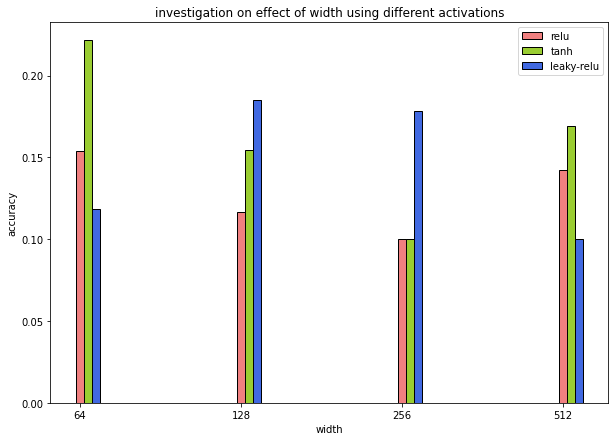

In [ ]:
fig = plt.subplots(figsize =(10, 7))

units = [64, 128, 256, 512]

acc1 = []
acc2 = []
acc3 = []

for u in units:
    nn1 = MLP((784, u, u, 10), (Relu, Relu, softmax))
    _, test_acc_relu = nn1.fit(X_train, Y_train, X_test, Y_test, epochs=1, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
    acc1.append(test_acc_relu)
    
    nn2 = MLP((784, u, u, 10), (tanh, tanh, softmax))
    _, test_acc_tanh = nn2.fit(X_train, Y_train, X_test, Y_test, epochs=1, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
    acc2.append(test_acc_tanh)

    nn3 = MLP((784, u, u, 10), (leakyRelu, leakyRelu, softmax))
    _, test_acc_leaky = nn3.fit(X_train, Y_train, X_test, Y_test, epochs=1, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)
    acc3.append(test_acc_leaky)

bar = 5
x = np.array([100,200,300,400])

plt.bar(x, acc1, color ='lightcoral', width = bar,
        edgecolor ='black', label ='relu')

plt.bar(x+bar, acc2, color ='yellowgreen', width = bar,
        edgecolor ='black', label ='tanh')

plt.bar(x+2*bar, acc3, color ='royalblue', width = bar,
        edgecolor ='black', label ='leaky-relu')


plt.title("investigation on effect of width using different activations")
plt.ylabel("accuracy")
plt.xticks(x,
        [64, 128, 256, 512])
plt.legend()
plt.xlabel("width")
plt.show()

    

## Varying number of images (with 2 hidden layers, 128 units, ReLU)

100%|██████████| 10/10 [00:00<00:00, 91.64it/s]


train acc 1.0
test acc 1.0


100%|██████████| 10/10 [00:00<00:00, 94.02it/s]


train acc 0.9
test acc 0.3


100%|██████████| 10/10 [00:00<00:00, 80.18it/s]


train acc 0.55
test acc 0.42


100%|██████████| 10/10 [00:00<00:00, 68.99it/s]


train acc 0.658
test acc 0.621


100%|██████████| 10/10 [00:00<00:00, 72.92it/s]


train acc 0.5006
test acc 0.5003


<Figure size 432x288 with 0 Axes>

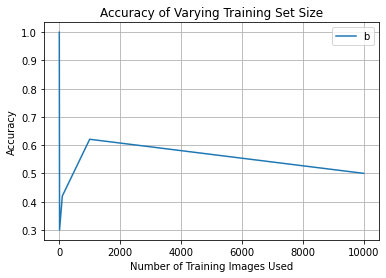

<Figure size 432x288 with 0 Axes>

In [ ]:
# Ploting the accuracy vs. training dataset size
n=X_train.shape[0]
size = [1,10,100,1000,10000]
accuracy_test = []

# loop over fractions
for s in size:
    np.random.seed(500)
    nn = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
    _, test_log = nn.fit(X_train[:s], Y_train[:s], X_test, Y_test, epochs=1500, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=False)
    accuracy_test.append(test_log)

x = np.array([10,20,30,40,50])
bar=5

# plot the training results
plt.bar(x, accuracy_test, color ='royalblue', width = bar,
        edgecolor ='black', label='MLP')


plt.xlabel('Number of Training Images Used')
plt.xticks(x,[1,10,100,1000,10000])
plt.ylabel('Accuracy')
plt.title("Accuracy of Varying Training Set Size")
plt.legend()
plt.grid()
plt.figure()


## More on Depth

In [ ]:

e = 2000

nn0 = MLP((784, 10), (softmax,))
_, test_acc_relu0 = nn0.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn1 = MLP((784, 128, 10), (Relu, softmax))
_, test_acc_relu1 = nn1.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn2 = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
_, test_acc_relu2 = nn2.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn3 = MLP((784, 128, 128, 128, 10), (Relu, Relu, Relu, softmax))
_, test_acc_relu3 = nn3.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn4 = MLP((784, 128, 128, 128, 128, 10), (Relu, Relu, Relu, Relu, softmax))
_, test_acc_relu4 = nn4.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn5 = MLP((784, 128, 128, 128, 128, 128, 10), (Relu, Relu, Relu, Relu, Relu, softmax))
_, test_acc_relu5 = nn5.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)

nn6 = MLP((784, 128, 128, 128, 128, 128, 128, 10), (Relu, Relu, Relu, Relu, Relu, Relu, softmax))
_, test_acc_relu6 = nn5.fit(X_train, Y_train, X_test, Y_test, epochs=e, batch_size=256, loss=Cross_Entropy,lambd = 0, learning_rate=0.1, plot=True)


bar = 3
x = [10,20,30,40,50,60,70]

plt.bar(x, [test_acc_relu0,test_acc_relu1,test_acc_relu2,test_acc_relu3,test_acc_relu4,test_acc_relu5,test_acc_relu6], 
        color ='royalblue', width = bar,
        edgecolor ='black', label='MLP')

plt.xlabel('Number of hidden layers')
plt.xticks(x,[0,1,2,3,4,5,6])
plt.ylabel('Accuracy')
plt.title("Accuracy of Varying Hidden layers")
# plt.legend()
# plt.grid()
plt.figure()

##check gradint

In [ ]:
mlp = MLP((784, 128, 128, 10), (Relu, Relu, softmax))
'''
(784, 128)
(128, 128)
(128, 10)
'''
mlp.check(X_train, Y_train)

